<a href="https://colab.research.google.com/github/tsp00/mass/blob/master/mass_ann.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/http://contents2.kocw.or.kr/KOCW/data/document/2020/edu1/bdu/hongseungwook1118/023.pdf

In [512]:
import numpy as np
from keras import layers,models
from sklearn import preprocessing

import matplotlib.pyplot as plt
#import numpy as np
import os

import pandas as pd

In [513]:
# Duflo-Zuker mass model dz10

#_______________________________________________________________________________
# dz10 parameters
b10_def = np.array([0.7043, 17.7418, 16.2562, 37.5562, 53.9017, 0.4711, 2.1307, 0.0210, 40.5356, 6.0632])


#_______________________________________________________________________________
def dz10_op (Z, N):
# DZ 10 operators, returns dyda2(shape=(2,10)), 2 is for spherical/deformed

   op=np.zeros(2)
   dx=np.zeros(2)
   qx=np.zeros(2)
   os=np.zeros(2)
   oei=np.zeros(2)
   dei=np.zeros(2)
   pp=np.zeros(2)
   # c*********
   nn= np.array([N, Z])
   A = N + Z
   t = np.abs(N-Z)
   r = np.power(A, 1./3.)
   #       !s=r*r
   rc = r*(1. - 0.25*np.power(t/A, 2)) 	# !      Charge radius
   ra = (rc*rc)/r
   # c--------
   z2 = Z*(Z - 1)

   # c********                          ! beginning of main loop
   dyda= np.zeros(10)
   y=np.zeros(2)
   dyda_table= np.zeros(shape=(2,10))
   for ndef in range(2): #= 0  ndef <= 1  ndef++) {	# !      ndef=0  spherical
      noc= np.zeros(shape=(2,18))
      onp= np.zeros(shape=(2,2,9))
      y[ndef] = 0.
      ju = 4 if (ndef == 1) else 0  	# !      nucleons associated to deform.
      for kk in range(10): #(int kk = 2  kk <= 10  kk++) {
         dyda[kk] = 0.
      #}
      dyda[0] = ra * (-z2 + 0.76*np.power(z2, 2./3.))/rc 	# ! ra times of Coulomb energy
      # c--------                          ! beginning of loop over N and Z
      for j in range (2): #(int j = 0  j <= 1  j++) {
         ncum = 0
         for i in range (100): #(int i = 0  i <= 100  i++) {
            id = i+2 if (i%2 == 0) else (i + 1)*(i - 1)//4 # sub-shells (ssh) j and r filli
            if (ncum + id >= nn[j]): # {
               ie=i
               break
            ncum += id
            noc[j][i] = id 	# !     nb of nucleons in each ssh
         # c--------
         ip = ie//2 	# !     HO number (p)
         pp[j] = ip
         moc = nn[j] - ncum 	# !+id
         noc[j][ie] = moc - ju 	# !     nb of nucleons in last ssh
         noc[j][ie + 1] = ju
         oei[j] = moc + ip*(ip - 1) if (ie%2 == 0) else moc - ju              # nb of nucleons in last EI she
         dei[j] = ip*(ip + 1) + 2   if (ie%2 == 0) else (ip + 1)*(ip + 2) + 2 # size of the EI shell

         qx[j] = oei[j]*(dei[j] - oei[j] - ju)/dei[j] 	# ! n*(D-n)/D        S3(j)
         dx[j] = qx[j]*(2*oei[j] - dei[j]) 	# ! n*(D-n)*(2n-D)/D  Q
         if (ndef == 1): qx[j] /= np.sqrt(dei[j]) 	# ! scaling for deformed
         # c--------
         for i in range (ie+2): #(int i = 0  i <= ie + 1  i++) {	# ! imax-1                             ! Amplitudes
            ip = i//2
            onp[j][0][ip] += noc[j][i]/np.sqrt((ip+1.)*(ip+2.)) 	# !    for FM term
            vm= 0.5*ip if (i%2 == 0) else -1. # for spin-orbit ter
            onp[j][1][ip] += noc[j][i]*vm
         # c--------
         op[j] = 0.
         os[j] = 0.
         for ip in range ((ie + 1)//2 +1): #(int ip = 0  ip <= (ie + 1)/2  ip++) {	# !ipm                !       FM and SO terms
            pi = ip
            den = np.power((pi + 1)*(pi + 2), 3./2.)
            op[j] += onp[j][0][ip] 	# ! FM
            os[j] += onp[j][1][ip]*((1. + onp[j][0][ip])*(pi*pi) + (1. - onp[j][0][ip])*(4*pi - 5))/den 	# ! SO

         op[j] *= op[j]

      # c--------                          ! end of loop over  N and Z
      dyda[1] = op[0] + op[1] 	# !   Master term (FM): volume
      dyda[2] = -dyda[1]/ra 	# !                     surface
      dyda[1] = dyda[1] + os[0] + os[1] 	# !   FM + SO
      dyda[3] = -t*(t + 2)/(r*r) 	# !   isospin term : volume
      dyda[4] = -dyda[3]/ra 	# !                : surface
      if (ndef == 0): # {	# ! sph.
         dyda[5] = dx[0] + dx[1] 	# !   S3  volume
         dyda[6] = -dyda[5]/ra 	# !       surface
         px = np.sqrt(pp[0]) + np.sqrt(pp[1])
         dyda[7] = qx[0]*qx[1]*(np.power(2, px)) 	# !   QQ sph.
      else: # {	# ! def.
         dyda[8] = qx[0]*qx[1] 	# !   QQ deform.

      dyda[4] += t*(1 - t)/(A*np.power(ra, 3)) 	# !   "Wigner term"
      # c--------                                 !   PAIRING
      if ((N%2==1) and (Z%2==1)): dyda[9] = t/A
      if (N > Z): # {
         if ((N%2==0) and (Z%2==1)): dyda[9] = 1 - t/A
         if ((N%2==1) and (Z%2==0)): dyda[9] = 1
      else: # {
         if ((N%2==0) and (Z%2==1)): dyda[9] = 1
         if ((N%2==1) and (Z%2==0)): dyda[9] = 1 - t/A

      if ((N%2==0) and (Z%2==0)): dyda[9] = 2 - t/A

      for mss in range(10): #(int mss = 1  mss <= 10  mss++) {
         dyda_table[ndef,mss]=  dyda[mss]/ra
      # c--------                            ! end of main loop
   return dyda_table


#_______________________________________________________________________________
def dz10 (Z, N, b = b10_def, verbosity = 0, opfun = dz10_op):
   dyda_table= opfun (Z, N)
   y= np.zeros(2)
   for ndef in range(2): #= 0  ndef <= 1  ndef++) {	# !      ndef=0  spherical
      for mss in range(10): #(int mss = 1  mss <= 10  mss++) {
         y[ndef] += dyda_table[ndef,mss]*b[mss]

   is_deformed = 0
   be= y[0]
   if (y[1] > y[0] and Z > 50):
      is_deformed = 1
      be= y[1]

   if verbosity <= 0 : return be
   if verbosity == 1 : return be, is_deformed

   return be, is_deformed,dyda_table[is_deformed]

In [514]:
dz10(50, 81)

1095.0984200112887

In [515]:
dz10(38,53)

787.8845069732481

In [516]:
dz10_op(38,53)

array([[-2.93374333e+02,  7.53494537e+01, -1.67503407e+01,
        -2.84065797e+00,  6.34260279e-01, -1.83898579e+01,
         4.14462015e+00,  4.44112951e+01,  0.00000000e+00,
         2.25375322e-01],
       [-2.93374333e+02,  7.48381163e+01, -1.64002438e+01,
        -2.84065797e+00,  6.34260279e-01,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -2.51928828e-02,
         2.25375322e-01]])

In [517]:
# Duflo-Zuker mass model dz33

#_______________________________________________________________________________
# dz33 parameters
b_28=np.array([
   9.0914*2, 6.3355*2, 4.5791, 19.8946, 1.7325, 7.5247,
   -7.1953, -39.9787, -0.3976, 0.8131, -0.7435, -3.7291,
   -0.1305, -0.6387, 0.4534, 2.0605, 0.3449, 1.4727,
   -1.0433, 0.0000, 5.2495, 0.0000, -32.1007, -151.1164,
   -4.6103, -32.4238, 37.3226*4, 52.1673*4, 0.9597, 3.0024,
   0.6977, 6.0390, 17.7960 ])

b_fit_1=np.array([
    18.3823114678441, 14.9654647147403, 5.16043547913969, 23.6791652365813, 1.69198437698102, 7.70752795386154,          # FM+, FS+, FS-
    -4.89968997566140, -41.9546818849829, -0.452541072665594, -0.115672475977305, -0.841966943307345, -4.26430263634212, # FC+, PM+, PS+
    -0.106021683952664, -0.562161540801153, 0.427309092386025, 1.96420799950015, 0.334218482733298, 1.31955010861289,    # PS-, S3,  SQ-
    -8.103099200805119/100, 8.20516288043133, 6.14976974664344, 5.32159824150776, -33.1968387296639, -158.618534804942,  # D3,  QQ+, D0
    -2.77690717089939, -24.5189516535313, 149.743976383871, 209.350547986690, 1.15196960067461, 3.72823843532976,        # QQ-, asym,SS
    0.702321263796662, 6.19508179596490, 9.74100193880679])                                                              # EC,  P1,  P2

b_fit_2=np.array([
    18.3221122504656, 14.5224438086702, 5.38508401938650, 24.8228141400897, 1.74698778464929, 7.91311926171185,
    -5.48565655334926, -42.8968460273137, -0.435917749563838, 3.908547722336988/100, -0.872068966794544, -4.42502282169325,
    -0.127419381208396, -0.668296738146491, 0.435870298399898, 2.00690509793684, 0.345745626292599, 1.40096007168900,
    1.28594442409618, 16.2884201477635, 5.79492771834656, 1.73923193482831, -33.4964972193808, -159.670174045318,
    -2.03517005308097, -18.7256526429027, 149.992913856565, 210.699329582436, 1.22681220517222, 4.06350605475340,
    0.701672917012658, 6.25922079319403, 8.99509716404338])

b_fit_3=np.array([
    18.6228397521178, 15.8127576459535, 3.41694534980079, 14.5804580920230, 1.35692505906094, 6.41683661357447,
    -1.94788844902597, -28.5255998068208, -0.644332680103499, -0.819341338674875, -0.535341673865479, -2.55311797652534,
    -0.136146129695100, -0.694037733724995, 0.455186789743238, 2.04846967472275, 0.338773739280799, 1.33999676626953,
    8.12815311636854, 50.3506134798718, -1.82915100886547, -39.8136431369429, -23.4674927512946, -108.181314678997,
    12.8175343210966, 65.0038503245761, 149.285763376006, 207.179983732669, 1.50059967529012, 4.31016747430967,
    0.701272742023415, 6.19590396338389, 8.07882516556805])


#_______________________________________________________________________________
# dz33 operators
def dz33_op (nz, nx):
   dyda= np.zeros(33)
   dyda_table= np.zeros(shape=(2,33))
   #    !C*****************************************
   #    !      data a/ 9.0914,   6.3355,   4.5791,  19.8946,   1.7325,   7.5247,
   #    !     &       -7.1953, -39.9787,  -0.3976,   0.8131,  -0.7435,  -3.7291,
   #    !     &       -0.1305,  -0.6387,   0.4534,   2.0605,   0.3449,   1.4727,
   #    !     &       -1.0433,   0.0000,   5.2495,   0.0000, -32.1007,-151.1164,
   #    !     &       -4.6103, -32.4238, -37.3226, -52.1673,   0.9597,   3.0024,
   #    !     &        0.6977,   6.0390,  17.7960/
   #    ! Data=1751 RMS= 0.330  (mars 95)
   #    !FM+*   9.09 fm+*   6.34 FS+*   4.58 fs+*  19.89 FS-*   1.73 fs-*   7.52
   #    !FC+*  -7.20 fc+* -39.98 PM+*  -0.40 pm+*   0.81 PS+*  -0.74 ps+*  -3.73
   #    !PS-*  -0.13 ps-*  -0.64 S3 *   0.45 s3 *   2.06 SQ-*   0.34 sq-*   1.47
   #    !D3 *  -1.04 d3     0.00 QQ+*   5.25 qq+    0.00  D0* -32.10  d0*-151.12
   #    !QQ-*  -4.61 qq-* -32.42  TT* -37.32  tt* -52.17  SS*   0.96  ss*   3.00
   #    ! C *   0.70 P0 *   6.04 P1 *  17.80
   #    !                    ----------------------
   #    ! 31 Coulomb
   #    ! 32+33 Pairing
   #    !
   imax = 18
   mo = 2
   maxp = 8
   nn= np.array([nx,nz])
   v = nx + nz
   t = np.abs(nx-nz)
   r = np.power(v, 1./3.)
   s = r*r
   rc = r*(1. - 0.25*np.power(t/v, 2))
   ra = (rc*rc)/r
   #    !******************
   for ndef in range(2): # ndef= 0->SPH# 1->DEF#
      jup= np.zeros(2)
      jud= np.zeros(2)
      #       !-----------
      ju= 4 if (ndef == 1 and nz > 50) else 0
      fyda= np.zeros(33)
      fyd0= np.zeros(33)
      dyda= np.zeros(33)

      noc= np.zeros(shape=(2,imax))
      onp= np.zeros(shape=(2,mo,maxp+1))
      ot= np.zeros(shape=(2,mo,maxp+1))

      onps= np.zeros(2)
      oei= np.zeros(2)
      dei= np.zeros(2)
      sshell= np.zeros(2)

      for j in range(2):
         ncum = 0
         for i1 in range(999+1):
            i = i1 + 1
            ie = i
            if (i%2 != 0):
               id = i + 1
               if (ncum < nn[j]): sshell[j] = 1.	# ! !sscouche  J
            else:
               id = i*(i - 2)/4
               if (ncum < nn[j]): sshell[j] = 2.	# ! ! SSC R

            ncum += id
            if (ncum > nn[j]): break
            noc[j][i1] = id

         i = ie
         ip = (i-1)//2	# ! !N0 couche HO
         moc = nn[j] - ncum + id
         if ((ndef == 1) and (i%2 != 0)):
            jud[j] = max(0, ju-moc)
            jup[j] = 0
         else:
            jup[j] = min(ju, moc)
            jup[j] = ju
            jud[j] = 0

         noc[j][i-1] = moc - jup[j] + jud[j]
         noc[j][i] = jup[j]
         noc[j][i - 2] -= jud[j]
         if (i%2 != 0):
            oei[j] = moc + ip*(ip - 1) - ju
            dei[j] = ip*(ip + 1) + 2
         else:
            oei[j] = moc - ju
            dei[j] = (ip + 1)*(ip + 2) + 2

         #          !C HERE,DEGENERACIES AND NUMBER OF ACTIVE PARTICLES  FOR  EI.
         ipl = 0
         vmr = 0.
         vmj = 0.
         for ii in range(imax):
            onps[j] = 0.
            ip = (ii)//2
            degi = (ip + 1)*(ip + 2)
            fac = 1./np.sqrt(degi)
            if (ip != ipl): ipl= ipl+1
            if ((2*ip + 1) == ii+1):
               vm2 = (0.5*ip)/(ip + 1)
               degr = ip*(ip - 1)
               if (ip > 2):
                  vmr = (0.5*(ip - 1))/ip
                  vmj = -1./ip
                  if (noc[j][ii] <= degr): onps[j] = noc[j][ii]*vmr
                  if (noc[j][ii] > degr): onps[j] = degr*vmr + (noc[j][ii] - degr)*vmj

            if ((2*ip + 1) != ii+1): vm2 = -1./(ip + 1)	# ! !SSc. j
            onp[j][1][ipl] += noc[j][ii]*vm2
            onp[j][0][ipl] += noc[j][ii]*fac
            fyd0[28] += onps[j]*(onp[j][0][ipl] + onp[j][1][ipl])

      # ! !END OF LOOP OVER FLUIDS, j
      if (ndef == 1):
         alfa = 0.
      else:
         alfa = 0.5

      facn = np.power(dei[0], alfa)
      facz = np.power(dei[1], alfa)
      dnnb = oei[0]*(dei[0] - oei[0])/dei[0]
      dzzb = oei[1]*(dei[1] - oei[1])/dei[1]
      qn = dnnb*facn/np.sqrt(dei[0])
      qz = dzzb*facz/np.sqrt(dei[1])
      di1n = dnnb*(2*oei[0] - dei[0])*facn*facn/(dei[0])
      di1z = dzzb*(2*oei[1] - dei[1])*facz*facz/(dei[1])
      s3 = di1z + di1n
      qq0 = (qn + qz)*(qn + qz)
      qq1 = (qn - qz)*(qn - qz)
      qqp = qq0 + qq1
      qqm = qq0 - qq1
      for m in range(mo):
         for i in range(maxp+1):
            ot[0][m][i] = onp[0][m][i] + onp[1][m][i]
            ot[1][m][i] = onp[0][m][i] - onp[1][m][i]

      op= np.zeros(shape=(2,3,2))
      op1= np.zeros(2)
      op2= np.zeros(2)

      for i in range(maxp+1):
         degi = (i + 1)*(i + 2)
         fac = np.sqrt(degi)
         for j in range(2):
            for m in range(mo):
               op[j][m][0] += ot[j][m][i]
               otx = ot[j][m][i]*ot[j][m][i]*fac
               op[j][m][1] += otx

      for j in range(2):
         for m in range(mo):
            opxx = op[j][m][0]*op[j][m][0]
            op[j][m][0] = opxx

      for j in range(2):
         for i in range(maxp+1):
            degi = (i + 1)*(i + 2)
            fac = np.sqrt(degi)
            op1[j] += ot[j][0][i]/fac
            op2[j] += ot[j][1][i]/fac

      for j in range(2):
         op[j][2][0] = op1[j]*op2[j]

      k = -1
      for l1 in range(2):
         for m in range(3):
            for j in range(2):
               k += 2
               fyd0[k - 1] = op[j][m][l1]

      for jf in range(0,16+1,4):
         fyd0[jf] += fyd0[jf + 2]
         fyd0[jf + 2] = fyd0[jf] - 2.*fyd0[jf + 2]

      fyda[0] = fyd0[0]/2
      fyda[2] = fyd0[4]
      fyda[4] = fyd0[6]
      fyda[6] = fyd0[8]
      fyda[8] = fyd0[12]
      fyda[10] = fyd0[16]
      fyda[12] = fyd0[18]
      fyda[26] = -t*(t + 2)/s/4
      fyda[28] = fyd0[28]
      if (ndef == 0):
         fyda[14] = s3
         fyda[16] = qqm
      else:
         fyda[18] = s3
         fyda[20] = qqp
         fyda[22] = 16. - qqm
         fyda[24] = qqm

      for mss in range(0,30,2):
         dyda[mss] = fyda[mss]/ra
         dyda[mss+1] = -dyda[mss]/ra

      #       !---------
      z2 = nz*(nz - 1)
      dyda[30] = (-z2 + 0.76*np.power(z2, 2./3.))/rc	# ! !Coulomb
      #       !---------
      rxz = 1./ra	# ! !Pairing
      vxz = 1./v
      txz = rxz*(t/v)
      uxz = rxz - txz
      for j in range(2):
         dyda[31] += -rxz
         if (sshell[j] == 2.): dyda[32] += vxz
         #          !        !effet de couche en 1/A
         if (nn[j]%2 == 0): dyda[31] += uxz

      j = 1	# ! !  Z>N
      if (nn[0] >= nn[1]): j = 0	# ! !  N>ou=Z
      #       !k = 3 - j
      if (nn[j]%2 == 0 and nn[1-j]%2 != 0): dyda[31] += -txz
      #       !********
      for mss in range(33):
         dyda_table[ndef,mss] = dyda[mss]
   return dyda_table


#_______________________________________________________________________________
def dz33 (nz, nx, b=b_fit_1, verbosity = 0, opfun = dz33_op):
   ym=np.zeros(2)
   #    !C*****************************************
   #    !      data a/ 9.0914,   6.3355,   4.5791,  19.8946,   1.7325,   7.5247,
   #    !     &       -7.1953, -39.9787,  -0.3976,   0.8131,  -0.7435,  -3.7291,
   #    !     &       -0.1305,  -0.6387,   0.4534,   2.0605,   0.3449,   1.4727,
   #    !     &       -1.0433,   0.0000,   5.2495,   0.0000, -32.1007,-151.1164,
   #    !     &       -4.6103, -32.4238, -37.3226, -52.1673,   0.9597,   3.0024,
   #    !     &        0.6977,   6.0390,  17.7960/
   #    ! Data=1751 RMS= 0.330  (mars 95)
   #    !FM+*   9.09 fm+*   6.34 FS+*   4.58 fs+*  19.89 FS-*   1.73 fs-*   7.52
   #    !FC+*  -7.20 fc+* -39.98 PM+*  -0.40 pm+*   0.81 PS+*  -0.74 ps+*  -3.73
   #    !PS-*  -0.13 ps-*  -0.64 S3 *   0.45 s3 *   2.06 SQ-*   0.34 sq-*   1.47
   #    !QQ-*  -4.61 qq-* -32.42  TT* -37.32  tt* -52.17  SS*   0.96  ss*   3.00
   #    ! C *   0.70 P0 *   6.04 P1 *  17.80
   #    !                    ----------------------
   #    ! 31 Coulomb
   #    ! 32+33 Pairing
   #    !
   #    !******************
   dyda_table= opfun (nz, nx)
   for ndef in range(2):
      for mss in range(33):
         ym[ndef] += dyda_table[ndef,mss]*b[mss]

   be = ym[0]
   if (nz > 50 and ym[1] > ym[0]):
      be = ym[1]
      is_deformed=1
   else:
      is_deformed=0

   if verbosity <= 0 : return be
   if verbosity == 1 : return be, is_deformed
   return be, is_deformed,dyda_table[is_deformed]

In [518]:
dz33(51,51,b=b_28)

834.8959940157664

In [519]:
dz33(51,51,b_fit_2)

834.196675824302

In [520]:
dz33_op(51,51)[1] - dz33_op(51,51)[0]

array([ -1.33131895,   0.28493692,  21.25801719,  -4.54976917,
        21.25801719,  -4.54976917,   1.47163189,  -0.31496754,
        -9.14018546,   1.95623767,  46.92222362, -10.04257756,
        46.92222362, -10.04257756,  12.44026338,  -2.66254027,
        -0.80343368,   0.17195573,   1.66789822,  -0.35697364,
         0.28804163,  -0.06164841,   3.13637495,  -0.6712659 ,
         0.28804163,  -0.06164841,   0.        ,   0.        ,
         1.56419136,  -0.33477768,   0.        ,   0.        ,
         0.        ])

In [521]:
dz33(84,132)

1675.981920245517

In [522]:
def opp(Z,N):
   be, is_pol, dy= dz33(Z,N, verbosity=2)
   r = np.power(Z+N, 1./3.)
   I= np.abs((N-Z)/(N+Z))

   rc = r*(1. - 0.25*np.power(I, 2))
   ra = (rc*rc)/r

   return {'Z':Z, 'N':N, 'I':I, '31': dy[31]*ra, '32': dy[32]*(N+Z)}

In [523]:
opp(10,20)

{'Z': 10,
 'N': 20,
 'I': 0.3333333333333333,
 '31': -0.6666666666666665,
 '32': 1.0}

In [524]:
for z in range (0,51):
    print(opp(z,10))

{'Z': 0, 'N': 10, 'I': 1.0, '31': -2.0, '32': 0.0}
{'Z': 1, 'N': 10, 'I': 0.8181818181818182, '31': -2.6363636363636362, '32': 0.0}
{'Z': 2, 'N': 10, 'I': 0.6666666666666666, '31': -1.3333333333333335, '32': 0.0}
{'Z': 3, 'N': 10, 'I': 0.5384615384615384, '31': -2.076923076923077, '32': 0.0}
{'Z': 4, 'N': 10, 'I': 0.42857142857142855, '31': -0.8571428571428573, '32': 0.0}
{'Z': 5, 'N': 10, 'I': 0.3333333333333333, '31': -1.6666666666666665, '32': 0.0}
{'Z': 6, 'N': 10, 'I': 0.25, '31': -0.5000000000000001, '32': 0.0}
{'Z': 7, 'N': 10, 'I': 0.17647058823529413, '31': -1.3529411764705883, '32': 1.0}
{'Z': 8, 'N': 10, 'I': 0.1111111111111111, '31': -0.22222222222222235, '32': 1.0}
{'Z': 9, 'N': 10, 'I': 0.05263157894736842, '31': -1.1052631578947367, '32': 0.0}
{'Z': 10, 'N': 10, 'I': 0.0, '31': 0.0, '32': 0.0}
{'Z': 11, 'N': 10, 'I': 0.047619047619047616, '31': -1.0476190476190477, '32': 0.0}
{'Z': 12, 'N': 10, 'I': 0.09090909090909091, '31': -0.18181818181818185, '32': 0.0}
{'Z': 13, 'N

In [525]:
#if __name__== '__main__':
#  main()

In [526]:
data2012 = pd.read_csv('https://raw.githubusercontent.com/tsp00/mass/master/ame2012.csv')

In [527]:
class AME:
   def __init__(self, raw):
      ##self.year = year
      self.raw = raw
      self.MEs= np.zeros(shape=(128,256))
      self.dMEs= np.zeros(shape=(128,256))
      self.BAs= np.zeros(shape=(128,256))
      self.dBAs= np.zeros(shape=(128,256))
      self.IsCalcs = np.full((128,256), 0)
      self.HasAnys = np.full((128,256), False)
      self.N1s= np.full(128, 0)
      self.N2s= np.full(128, 0)
      self.ZmaxValue= 0

      for z in range (128):
         self.N1s[z]= 999
         self.N2s[z]= 0

      self.ZNs=[]
      for k in range(raw.shape[0]):
         Z= raw['Z'][k]
         N= raw['N'][k]
         self.ZNs.append((Z,N))
         A= Z+N
         self.MEs[Z,N]= raw['MASSEXCESS'][k]/1000
         self.dMEs[Z,N]= raw['dMASSEXCESS'][k]/1000
         self.BAs[Z,N]= raw['BINDINGENERGY_A'][k]/1000
         self.dBAs[Z,N]= raw['dBINDINGENERGY_A'][k]/1000
         self.IsCalcs[Z,N]= raw['IsCalculated'][k]
         self.HasAnys[Z,N]= True
         if (N > self.N2s[Z]): self.N2s[Z]= N
         if (N < self.N1s[Z]): self.N1s[Z]= N
         if (Z > self.ZmaxValue): self.ZmaxValue = Z

         BE20= (Z+N) * raw['BINDINGENERGY_A'][k]/1000
         dBE20= (Z+N) * raw['dBINDINGENERGY_A'][k]/1000
         self.IsCalcs[Z,N]= raw['IsCalculated'][k] == 1
   def ME(self,Z,N): return self.MEs[Z,N]
   def dME(self,Z,N): return self.sMEs[Z,N]
   def BA(self,Z,N): return self.BAs[Z,N]
   def dBA(self,Z,N): return self.dBAs[Z,N]
   def BE(self,Z,N): return (Z+N)*self.BAs[Z,N]
   def dBE(self,Z,N): return (Z+N)*self.dBAs[Z,N]
   def IsCalculated(self,Z,N): return self.IsCalcs[Z,N]==1
   def IsCalc(self,Z,N): return self.IsCalcs[Z,N]
   def HasAny(self,Z,N): return self.HasAnys[Z,N]
   def N1(self,Z): return self.N1s[Z]
   def N2(self,Z): return self.N2s[Z]
   def N1N2(self,Z): return self.N1s[Z], self.N2s[Z]
   def Zmax(self): return self.ZmaxValue
   def Size(self): return self.raw.shape[0]
   def ZN(self,k): return self.ZNs[k]
   def BEdata(self,k):
      Z,N= self.ZNs[k]
      return Z,N, (Z+N)*self.BAs[Z,N],(Z+N)*self.dBAs[Z,N], self.IsCalcs[Z,N]

In [528]:
ame2012= AME(data2012)
ame2012.BE(20,30)

427.50815000000006

In [529]:
ame2012.HasAny(20,30)

True

In [530]:
ame2012.N1N2(20)

(14, 38)

In [531]:
ame2012.BEdata(100)

(9, 11, 154.40268, 3.9999999999999996e-05, 0)

In [532]:
data2012

,N,Z,A,EL,MASSEXCESS,dMASSEXCESS,BINDINGENERGY_A,dBINDINGENERGY_A,IsCalculated
0,1,0,1,n,8071.31714,0.00046,0.000,0.000,0
1,0,1,1,H,7288.97059,0.00009,0.000,0.000,0
2,1,1,2,H,13135.72174,0.00011,1112.283,0.000,0
3,2,1,3,H,14949.80611,0.00221,2827.266,0.001,0
4,1,2,3,He,14931.21551,0.00233,2572.681,0.001,0
...,...,...,...,...,...,...,...,...,...
3348,176,117,293,Eh,193970.00000,828.00000,7097.000,3.000,1
3349,175,118,293,Ei,198932.00000,728.00000,7077.000,2.000,1
3350,177,117,294,Eh,196044.00000,687.00000,7093.000,2.000,1
3351,176,118,294,Ei,199266.00000,664.00000,7080.000,2.000,1


In [533]:
data2012.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3353 entries, 0 to 3352
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   N                 3353 non-null   int64  
 1   Z                 3353 non-null   int64  
 2   A                 3353 non-null   int64  
 3   EL                3353 non-null   object 
 4   MASSEXCESS        3353 non-null   float64
 5   dMASSEXCESS       3353 non-null   float64
 6   BINDINGENERGY_A   3353 non-null   float64
 7   dBINDINGENERGY_A  3353 non-null   float64
 8   IsCalculated      3353 non-null   int64  
dtypes: float64(4), int64(4), object(1)
memory usage: 235.9+ KB


In [534]:
def dame(ame=ame2012, model=dz10, b= b10_def):
   tmp=[]
   for k in range(ame.Size()):
      Z,N,BE,dBE,IsCalc = ame.BEdata(k)
      theory= model(Z,N,b)
      res= (Z,N, theory-BE, dBE, IsCalc, theory, BE)
      tmp.append(res)
   return tmp

In [535]:
ame2012.Size()

3353

In [536]:
m10=dame()

In [537]:
def weight0(Z,N,dBE=0, isCalc=0):
  #if Z>=20 and N>20 and dBE <= 0.100 and isCalc==0: return 1
  if Z>=6 and N+Z>=12 and dBE <= 0.100: return 1
  return 0

def weight1(Z,N,dBE=0, isCalc=0):
  if Z>=20 and N>20: return 1/(0.100*0.100 + (1+isCalc)*dBE*dBE)
  return 0

def weight2(Z,N,dBE=0, isCalc=0):
  if Z>=20 and N>20: return 1/(0.100*0.100 + (1+3*isCalc)*dBE*dBE)
  return 0

In [538]:
def eval_sigma(lst, weight= weight0):
   y2=0
   denorm =0
   ncount=0
   for k in range(len(lst)):
      Z, N, err, tol, iscalc, be, be_data =lst[k]
      w=weight(Z,N,tol, iscalc)
      y2 += w * err * err
      denorm += w
      if w > 0 : ncount += 1
   return np.sqrt(y2/denorm), np.sqrt(ncount/denorm), ncount, len(lst)

In [539]:
eval_sigma(m10)

(0.5712570423361005, 1.0, 2319, 3353)

In [540]:
eval_sigma(m10)

(0.5712570423361005, 1.0, 2319, 3353)

In [541]:
eval_sigma(m10,weight1)

(0.5803640554165157, 0.11892672767914904, 2971, 3353)

In [542]:
eval_sigma(m10,weight2)

(0.565763660964234, 0.11949856257949182, 2971, 3353)

In [543]:
m33=dame(model=dz33, b=b_fit_1)

In [544]:
eval_sigma(m33,weight0)

(0.38519874057860265, 1.0, 2319, 3353)

In [545]:
eval_sigma(m33,weight1)

(0.3743922937080574, 0.11892672767914904, 2971, 3353)

In [546]:
eval_sigma(m33,weight2)

(0.3630309334197799, 0.11949856257949182, 2971, 3353)

In [547]:
#dd(981,dz33)

In [548]:
dz33(21,33)

451.7344323930868

In [549]:
dz10(21,33)

452.02928153844067

In [550]:
dz33_op(30,40)

array([[ 5.65548216e+01, -1.38637231e+01,  3.06422219e+00,
        -7.51156609e-01,  0.00000000e+00, -0.00000000e+00,
         9.59253276e-01, -2.35149214e-01,  1.12759733e+02,
        -2.76416701e+01,  1.37036182e+01, -3.35927448e+00,
         0.00000000e+00, -0.00000000e+00, -5.34846055e+00,
         1.31110972e+00,  9.72447372e+00, -2.38383585e+00,
         0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
         0.00000000e+00, -0.00000000e+00, -4.32978304e-01,
         1.06139338e-01,  3.13047762e+00, -7.67398319e-01,
        -1.95289722e+02, -7.00393643e-02,  2.85714286e-02],
       [ 5.65548216e+01, -1.38637231e+01,  3.06422219e+00,
        -7.51156609e-01,  0.00000000e+00, -0.00000000e+00,
         9.59253276e-01, -2.35149214e-01,  1.12759733e+02,
        -2.76416701e+01,  1.37036182e+01, -3.35927448e+00,
         0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        -0.00000000e+00,  0.00000000e+00, -0.00000000e+

In [551]:
#_______________________________________________________________________________
# dz33 operators
def dz33_op2 (nz, nx):
   dyda= np.zeros(33)
   dyda_table= np.zeros(shape=(2,33))
   #    !C*****************************************
   #    !      data a/ 9.0914,   6.3355,   4.5791,  19.8946,   1.7325,   7.5247,
   #    !     &       -7.1953, -39.9787,  -0.3976,   0.8131,  -0.7435,  -3.7291,
   #    !     &       -0.1305,  -0.6387,   0.4534,   2.0605,   0.3449,   1.4727,
   #    !     &       -1.0433,   0.0000,   5.2495,   0.0000, -32.1007,-151.1164,
   #    !     &       -4.6103, -32.4238, -37.3226, -52.1673,   0.9597,   3.0024,
   #    !     &        0.6977,   6.0390,  17.7960/
   #    ! Data=1751 RMS= 0.330  (mars 95)
   #    !FM+*   9.09 fm+*   6.34 FS+*   4.58 fs+*  19.89 FS-*   1.73 fs-*   7.52
   #    !FC+*  -7.20 fc+* -39.98 PM+*  -0.40 pm+*   0.81 PS+*  -0.74 ps+*  -3.73
   #    !PS-*  -0.13 ps-*  -0.64 S3 *   0.45 s3 *   2.06 SQ-*   0.34 sq-*   1.47
   #    !D3 *  -1.04 d3     0.00 QQ+*   5.25 qq+    0.00  D0* -32.10  d0*-151.12
   #    !QQ-*  -4.61 qq-* -32.42  TT* -37.32  tt* -52.17  SS*   0.96  ss*   3.00
   #    ! C *   0.70 P0 *   6.04 P1 *  17.80
   #    !                    ----------------------
   #    ! 31 Coulomb
   #    ! 32+33 Pairing
   #    !
   imax = 18
   #mo = 2
   maxp = 8
   nn= np.array([nx,nz])
   v = nx + nz
   t = np.abs(nx-nz)
   r = np.power(v, 1./3.)
   #s = r*r
   rc = r*(1. - 0.25*np.power(t/v, 2))
   ra = (rc*rc)/r
   #    !******************
   for ndef in range(2): # ndef= 0->SPH# 1->DEF#
      jup= np.zeros(2)
      jud= np.zeros(2)
      #       !-----------
      ju= 4 if (ndef == 1 and nz > 50) else 0
      fyda= np.zeros(33)
      dyda= np.zeros(33)
      ss=0

      noc= np.zeros(shape=(2,imax))
      n_onp= np.zeros(shape=(2,maxp+1))
      s_onp= np.zeros(shape=(2,maxp+1))
      n_ot= np.zeros(shape=(2,maxp+1))
      s_ot= np.zeros(shape=(2,maxp+1))

      oei= np.zeros(2)
      dei= np.zeros(2)
      sshell= np.zeros(2)

      for j in range(2):
         ncum = 0
         for i in range(999+1):
            #i = i1 + 1
            ie = i
            if (i%2 == 0):
               id = i + 2
               if (ncum < nn[j]): sshell[j] = 1	# ! !sscouche  J
            else:
               id = (i+1)*(i - 1)/4
               if (ncum < nn[j]): sshell[j] = 2	# ! ! SSC R

            ncum += id
            if (ncum > nn[j]): break
            noc[j][i] = id

         i = ie
         ip = i//2	# ! !N0 couche HO
         moc = nn[j] - ncum + id
         if ((ndef == 1) and (i%2 == 0)):
            jup[j] = 0
            jud[j] = max(0, ju-moc)
         else:
            #jup[j] = min(ju, moc)
            jup[j] = ju
            jud[j] = 0

         noc[j][i] = moc - jup[j] + jud[j]
         noc[j][i+1] = jup[j]
         noc[j][i - 1] -= jud[j]
         oei[j] = moc + ip*(ip - 1) - ju if (i%2 == 0) else moc - ju
         dei[j] = ip*(ip + 1) + 2        if (i%2 == 0) else (ip + 1)*(ip + 2) + 2

         #          !C HERE,DEGENERACIES AND NUMBER OF ACTIVE PARTICLES  FOR  EI.
         #ipl = 0
         vmr = 0.
         vmj = 0.
         for ii in range(imax):
            onps = 0.
            ip = (ii)//2
            #degi = (ip + 1)*(ip + 2)
            fac = 1./np.sqrt((ip + 1)*(ip + 2))
            #if (ip != ipl): ipl= ipl+1
            if (2*ip == ii):
               vm2 = (0.5*ip)/(ip + 1)
               degr = ip*(ip - 1)
               if (ip > 2):
                  vmr = (0.5*(ip - 1))/ip
                  vmj = -1./ip
                  onps = noc[j][ii]*vmr if (noc[j][ii] <= degr) else degr*vmr + (noc[j][ii] - degr)*vmj

            if (2*ip != ii): vm2 = -1./(ip + 1)	# ! !SSc. j
            s_onp[j][ip] += noc[j][ii]*vm2
            n_onp[j][ip] += noc[j][ii]*fac
            ss += onps*(n_onp[j][ip] + s_onp[j][ip])

      # ! !END OF LOOP OVER FLUIDS, j
      alfa = 0 if (ndef == 1) else 0.5

      facn = np.power(dei[0], alfa)
      facz = np.power(dei[1], alfa)
      qn = oei[0]*(dei[0] - oei[0])/dei[0]*facn/np.sqrt(dei[0])
      qz = oei[1]*(dei[1] - oei[1])/dei[1]*facz/np.sqrt(dei[1])
      s3 = qn*(2*oei[0] - dei[0])*facn/np.sqrt(dei[0]) + qz*(2*oei[1] - dei[1])*facz/np.sqrt(dei[1])
      qqp = (qn + qz)*(qn + qz) + (qn - qz)*(qn - qz)
      qqm = (qn + qz)*(qn + qz) - (qn - qz)*(qn - qz)

      for i in range(maxp+1):
            n_ot[0][i] = n_onp[0][i] + n_onp[1][i]
            n_ot[1][i] = n_onp[0][i] - n_onp[1][i]
            s_ot[0][i] = s_onp[0][i] + s_onp[1][i]
            s_ot[1][i] = s_onp[0][i] - s_onp[1][i]

      #op= np.zeros(shape=(2,3,2))
      n_op= np.zeros(shape=(2))
      n_op_sqr= np.zeros(shape=(2))
      s_op= np.zeros(shape=(2))
      s_op_sqr= np.zeros(shape=(2))
      x_op= np.zeros(shape=(2))

      for i in range(maxp+1):
         fac = np.sqrt((i + 1)*(i + 2))
         for j in range(2):
               n_op[j] += n_ot[j][i]
               n_op_sqr[j] += (n_ot[j][i]**2)*fac
               s_op[j] += s_ot[j][i]
               s_op_sqr[j] += (s_ot[j][i]**2)*fac

      for j in range(2):
         op1,op2=0,0
         for i in range(maxp+1):
            fac = np.sqrt((i + 1)*(i + 2))
            op1 += n_ot[j][i]/fac
            op2 += s_ot[j][i]/fac
         x_op[j] = op1*op2

      fyda[ 0] = (n_op[0]**2 + n_op[1]**2)/2
      fyda[ 2] = s_op[0]**2 + s_op[1]**2
      fyda[ 4] = s_op[0]**2 - s_op[1]**2
      fyda[ 6] = x_op[0]    + x_op[1]
      fyda [8] = n_op_sqr[0] + n_op_sqr[1]
      fyda[10] = s_op_sqr[0] + s_op_sqr[1]
      fyda[12] = s_op_sqr[0] - s_op_sqr[1]
      fyda[26] = -t*(t + 2)/(4*r*r)
      fyda[28] = ss
      if (ndef == 0):
         fyda[14] = s3
         fyda[16] = qqm
      else:
         fyda[18] = s3
         fyda[20] = qqp
         fyda[22] = 16. - qqm
         fyda[24] = qqm

      for mss in range(0,30,2):
         dyda[mss] = fyda[mss]/ra
         dyda[mss+1] = -dyda[mss]/ra

      #       !---------
      z2 = nz*(nz - 1)
      dyda[30] = (-z2 + 0.76*np.power(z2, 2./3.))/rc	# ! !Coulomb
      #       !---------
      #rxz = 1/ra	# ! !Pairing
      for j in range(2):
         dyda[31] += -1/ra
         if (sshell[j] == 2.): dyda[32] += 1/v
         #          !        !effet de couche en 1/A
         if (nn[j]%2 == 0): dyda[31] += 1/ra - (t/v)/ra

      j = 1	# ! !  Z>N
      if (nn[0] >= nn[1]): j = 0	# ! !  N>ou=Z
      if (nn[j]%2 == 0 and nn[1-j]%2 != 0): dyda[31] += -(t/v)/ra
      #       !********
      for mss in range(33):
         dyda_table[ndef,mss] = dyda[mss]
   return dyda_table


In [552]:
dz33_op2(32,45) - dz33_op(32,45)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]])

In [553]:
def chop(expr, delta=10**-15):
   return np.ma.masked_inside(expr, -delta, delta).filled(0)

In [554]:
chop(dz33_op2(31,45) - dz33_op(31,45))

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]])

In [555]:
chop(dz33_op2(32,44) - dz33_op(32,44))

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]])

In [556]:
chop(dz33_op2(32,44))

array([[ 6.14910850e+01, -1.46995783e+01,  3.13636469e+00,
        -7.49754836e-01,  3.05986799e+00, -7.31468132e-01,
         1.34700786e+00, -3.22005175e-01,  1.16061010e+02,
        -2.77446382e+01,  1.52564259e+01, -3.64708197e+00,
         0.00000000e+00,  0.00000000e+00, -5.21568407e-01,
         1.24682068e-01,  1.36556092e+01, -3.26440324e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -5.59585281e-01,
         1.33770085e-01,  3.88835676e+00, -9.29520185e-01,
        -2.17703441e+02, -7.54901641e-02,  1.31578947e-02],
       [ 6.14910850e+01, -1.46995783e+01,  3.13636469e+00,
        -7.49754836e-01,  3.05986799e+00, -7.31468132e-01,
         1.34700786e+00, -3.22005175e-01,  1.16061010e+02,
        -2.77446382e+01,  1.52564259e+01, -3.64708197e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+

In [557]:
class Boston_ANN(models.Model):
  def __init__(self, Nin, Nh, Nout):
    hidden=layers.Dense(Nh)
    output= layers.Dense(Nout)
    relu= layers.Activation('relu')

    x= layers.Input(shape=(Nin,))
    h= relu(hidden(x))
    y= output(h)

    super().__init__(x,y)
    self.compile(loss='mse',optimizer='sgd')

from keras import datasets
from keras.datasets import boston_housing

# 모델 학습 후 정보가 담긴 history 내용을 토대로 선 그래프를 그리는 함수 설정

def plot_acc(history, title=None):        # Accuracy(정확도) Visualization
    # summarize history for accuracy
    if not isinstance(history, dict):
        history = history.history

    plt.plot(history['accuracy'])        # accuracy
    plt.plot(history['val_accuracy'])    # validation accuracy
    if title is not None:
        plt.title(title)
    plt.ylabel('Accracy')
    plt.xlabel('Epoch')
    plt.legend(['Training data', 'Validation data'], loc=0)
    # plt.show()

def plot_loss(history, title=None, yscale='linear'):     # Loss Visualization
    # summarize history for loss
    if not isinstance(history, dict):
        history = history.history

    plt.plot(history['loss'])           # loss
    plt.plot(history['val_loss'])       # validation
    if title is not None:
        plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training data', 'Validation data'], loc=0)
    plt.yscale(yscale)
    plt.show()

#import matplotlib.pyplot as plt
#from keras import plot_loss
#from keraspp.skeras import plot_loss

def boston_run(epochs=100, batch=1000, yscale='linear'):
  Nin=13
  Nh=5
  Nout=1
  model= Boston_ANN(Nin,Nh,Nout)
  (X_train, y_train), (X_test, y_test)= boston_housing.load_data()
  scaler= preprocessing.MinMaxScaler()
  X_train= scaler.fit_transform(X_train)
  X_test=scaler.transform(X_test)

  history= model.fit(X_train, y_train, epochs=epochs, batch_size=batch, validation_split=0.2, verbose=2)
  performance_test=model.evaluate(X_test, y_test, batch_size=batch)
  print('Test Loss and Accuracy ->', performance_test)

  plot_loss(history,yscale=yscale)
  plt.show()

  predictions=model.predict(X_test)
  plt.plot(y_test)
  plt.plot(predictions)
  plt.title('prediction')
  plt.xlabel('Y')
  plt.xlabel('test')
  plt.legend(['y_test','predictions'], loc=0)
  plt.show()

Epoch 1/10
1/1 - 2s - loss: 593.1862 - val_loss: 621.8831 - 2s/epoch - 2s/step
Epoch 2/10
1/1 - 0s - loss: 551.4058 - val_loss: 601.2348 - 89ms/epoch - 89ms/step
Epoch 3/10
1/1 - 0s - loss: 532.2382 - val_loss: 580.8110 - 241ms/epoch - 241ms/step
Epoch 4/10
1/1 - 0s - loss: 513.2125 - val_loss: 559.2671 - 79ms/epoch - 79ms/step
Epoch 5/10
1/1 - 0s - loss: 493.3069 - val_loss: 532.7054 - 115ms/epoch - 115ms/step
Epoch 6/10
1/1 - 0s - loss: 469.0995 - val_loss: 489.6421 - 150ms/epoch - 150ms/step
Epoch 7/10
1/1 - 0s - loss: 430.3098 - val_loss: 411.0323 - 158ms/epoch - 158ms/step
Epoch 8/10
1/1 - 0s - loss: 358.7771 - val_loss: 276.2342 - 90ms/epoch - 90ms/step
Epoch 9/10
1/1 - 0s - loss: 238.9688 - val_loss: 144.2107 - 93ms/epoch - 93ms/step
Epoch 10/10
1/1 - 0s - loss: 131.6740 - val_loss: 110.1380 - 164ms/epoch - 164ms/step
1/1 [==============================] - 0s 71ms/step - loss: 115.8153
Test Loss and Accuracy -> 115.81532287597656


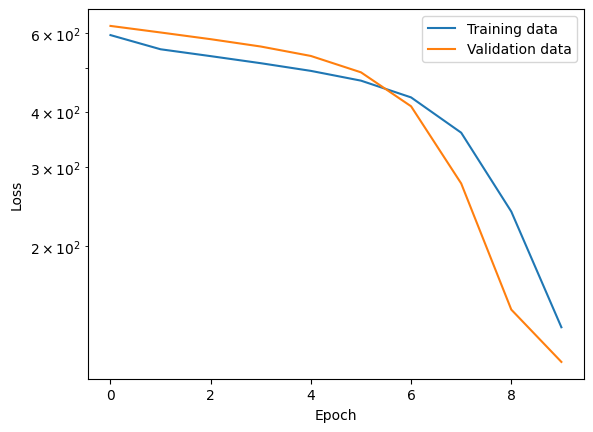

4/4 [==============================] - 0s 7ms/step


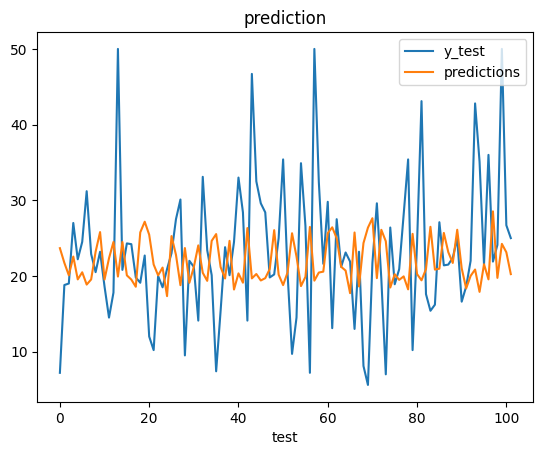

In [558]:
boston_run(10,1000,'log')

In [559]:
boston_housing.load_data()

((array([[1.23247e+00, 0.00000e+00, 8.14000e+00, ..., 2.10000e+01,
          3.96900e+02, 1.87200e+01],
         [2.17700e-02, 8.25000e+01, 2.03000e+00, ..., 1.47000e+01,
          3.95380e+02, 3.11000e+00],
         [4.89822e+00, 0.00000e+00, 1.81000e+01, ..., 2.02000e+01,
          3.75520e+02, 3.26000e+00],
         ...,
         [3.46600e-02, 3.50000e+01, 6.06000e+00, ..., 1.69000e+01,
          3.62250e+02, 7.83000e+00],
         [2.14918e+00, 0.00000e+00, 1.95800e+01, ..., 1.47000e+01,
          2.61950e+02, 1.57900e+01],
         [1.43900e-02, 6.00000e+01, 2.93000e+00, ..., 1.56000e+01,
          3.76700e+02, 4.38000e+00]]),
  array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
         17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
         32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
         23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
         12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.

In [560]:
(X_1, y_1), (X_2, y_2)= boston_housing.load_data()

In [561]:
X_1.shape

(404, 13)

In [562]:
y_1

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

In [563]:
X_2.shape

(102, 13)

In [564]:
y_2.shape

(102,)

In [565]:
from sklearn.model_selection import train_test_split
#train_x, valid_x, train_y, valid_y = train_test_split(wu_data, data_y, test_size=0.33, random_state=7)

In [566]:
dz10_op(38,53)

array([[-2.93374333e+02,  7.53494537e+01, -1.67503407e+01,
        -2.84065797e+00,  6.34260279e-01, -1.83898579e+01,
         4.14462015e+00,  4.44112951e+01,  0.00000000e+00,
         2.25375322e-01],
       [-2.93374333e+02,  7.48381163e+01, -1.64002438e+01,
        -2.84065797e+00,  6.34260279e-01,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -2.51928828e-02,
         2.25375322e-01]])

In [567]:
dz10_op(38,53).shape

(2, 10)

In [582]:
def gen10(ame=ame2012):
   xs=[]
   ys=[]
   for k in range(ame.Size()):
      Z,N,BE,dBE,IsCalc= ame.BEdata(k)
      A=N+Z
      A1=1
      #if (Z>=6 and Z+N >= 12 and dBE <= 0.1):
      if (Z>=20 and N >= 20 and dBE <= 0.1):
         opv=dz10_op(Z,N)
         #for k in range(opv.shape[1]):
         #    opv[0,k] *= 1/A1
         #    opv[1,k] *= 1/A1
         s= opv[0] # spherical
         d= opv[1] # defomred
         #x= np.array([Z,N,d[0],d[1],d[2],d[3],d[4],s[5],s[6],s[7], s[8],s[9]])
         #x= np.array([d[0],d[1],d[2],d[3],d[4],s[5],s[6],s[7], s[8],s[9]])
         #x= np.array([d[0],d[1],d[2],s[5],s[6],s[7],s[8],s[9]])
         x= np.array([opv[1,0],opv[1,1],opv[1,2],opv[0,5],opv[0,6],opv[1,7],opv[1,8],opv[1,9]])
         #x= np.array([Z,N])
         #xs.append(x)
         xs.append(x)
         #y= (BE- dz10(Z,N))/A1
         y= (BE- dz10(Z,N))
         #y= BE
         ys.append(y)
   return np.array(xs), np.array(ys)

In [569]:
gen10()

(array([[-9.89866284e+00,  7.33508820e+00, -3.54306947e+00, ...,
          0.00000000e+00,  1.74716093e+00,  8.73580465e-01],
        [-1.44344285e+01,  7.14876496e+00, -3.10503609e+00, ...,
          0.00000000e+00,  4.62447743e-01,  7.38200911e-02],
        [-2.01613084e+01,  7.90693742e+00, -3.51000837e+00, ...,
          0.00000000e+00,  1.22534420e-01,  7.70177063e-01],
        ...,
        [-1.80899885e+03,  2.30265026e+02, -3.59899120e+01, ...,
          0.00000000e+00,  3.37572441e-01,  2.85664704e-01],
        [-1.80728263e+03,  2.31331545e+02, -3.61415592e+01, ...,
          0.00000000e+00,  3.34067911e-01,  1.57302278e-01],
        [-1.80389303e+03,  2.33478391e+02, -3.64481727e+01, ...,
          0.00000000e+00,  3.24274147e-01,  1.57097355e-01]]),
 array([ 0.63065475,  0.13245971,  0.94737409, ..., -2.46801985,
        -2.46363192, -3.38781186]))

In [589]:
class AME_ANN(models.Model):
  def __init__(self, Nin, Nh1, Nh2):
    hidden1=layers.Dense(Nh1)
    hidden2=layers.Dense(Nh2)
    output= layers.Dense(1)
    relu= layers.Activation('relu')

    x= layers.Input(shape=(Nin,))
    h1= relu(hidden1(x))
    h2= relu(hidden2(h1))
    y= output(h2)

    super().__init__(x,y)
    self.compile(loss='mse',optimizer='sgd')

  '''
  def __init__(self, Nin, Nh1, Nh2, Nh3):
    hidden1=layers.Dense(Nh1)
    hidden2=layers.Dense(Nh2)
    hidden3=layers.Dense(Nh3)
    output= layers.Dense(1)
    relu= layers.Activation('relu')

    x= layers.Input(shape=(Nin,))
    h1= relu(hidden1(x))
    h2= relu(hidden2(h1))
    h3= relu(hidden3(h2))
    y= output(h3)

    super().__init__(x,y)
    self.compile(loss='mse',optimizer='sgd')
    '''
#from keras import datasets
#from keras.datasets import boston_housing


def ame_run(ame=ame2012, epochs=100, batch=2000, yscale='linear'):
  #(X_train, y_train), (X_test, y_test)= boston_housing.load_data()
  #X_train, X_test, y_train, y_test = train_test_split(xst, yst, test_size=0.33, random_state=7)
  xst, yst= gen10()
  X_train, X_test, y_train, y_test = train_test_split(xst, yst, test_size=0.33, random_state=7)

  scaler= preprocessing.MinMaxScaler()
  X_train= scaler.fit_transform(X_train)
  X_test=scaler.transform(X_test)

  Nin=(X_train.shape)[1]
  #model= AME_ANN(Nin,Nh1,Nh2,Nh3)
  model= AME_ANN(Nin,8,4)

  history= model.fit(X_train, y_train, epochs=epochs, batch_size=batch, validation_split=0.2, verbose=2)
  performance_test=model.evaluate(X_test, y_test, batch_size=batch)
  print('Test Loss and Accuracy ->', performance_test)

  plot_loss(history,yscale=yscale)
  plt.show()

  #predictions=model.predict(X_test)
  #plt.plot(y_test)
  #plt.plot(predictions)
  #plt.title('prediction')
  #plt.xlabel('Y')
  #plt.xlabel('test')
  #plt.legend(['y_test','predictions'], loc=0)
  #plt.show()

Epoch 1/100
1/1 - 1s - loss: 0.5089 - val_loss: 0.3858 - 677ms/epoch - 677ms/step
Epoch 2/100
1/1 - 0s - loss: 0.4680 - val_loss: 0.3567 - 37ms/epoch - 37ms/step
Epoch 3/100
1/1 - 0s - loss: 0.4381 - val_loss: 0.3353 - 43ms/epoch - 43ms/step
Epoch 4/100
1/1 - 0s - loss: 0.4160 - val_loss: 0.3194 - 38ms/epoch - 38ms/step
Epoch 5/100
1/1 - 0s - loss: 0.3996 - val_loss: 0.3075 - 39ms/epoch - 39ms/step
Epoch 6/100
1/1 - 0s - loss: 0.3872 - val_loss: 0.2986 - 42ms/epoch - 42ms/step
Epoch 7/100
1/1 - 0s - loss: 0.3779 - val_loss: 0.2919 - 44ms/epoch - 44ms/step
Epoch 8/100
1/1 - 0s - loss: 0.3707 - val_loss: 0.2868 - 39ms/epoch - 39ms/step
Epoch 9/100
1/1 - 0s - loss: 0.3652 - val_loss: 0.2828 - 50ms/epoch - 50ms/step
Epoch 10/100
1/1 - 0s - loss: 0.3609 - val_loss: 0.2797 - 41ms/epoch - 41ms/step
Epoch 11/100
1/1 - 0s - loss: 0.3575 - val_loss: 0.2774 - 39ms/epoch - 39ms/step
Epoch 12/100
1/1 - 0s - loss: 0.3548 - val_loss: 0.2756 - 41ms/epoch - 41ms/step
Epoch 13/100
1/1 - 0s - loss: 0.352

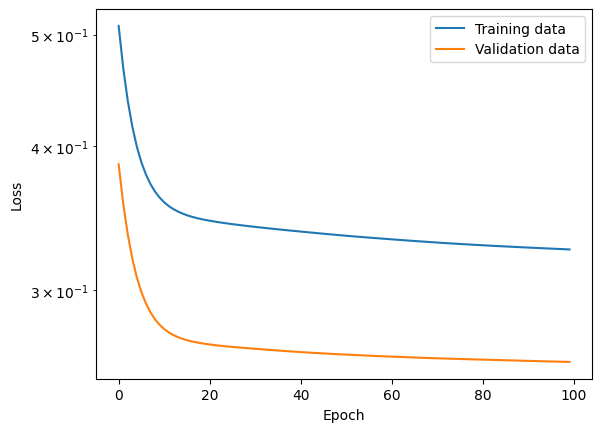

In [590]:
ame_run(yscale='log',epochs=100)